In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

In this demo, we will show how vanilla Recurrent Neural Networks (RNNs) can be used to solve time-series extrapolation problems -- That is, problems that require you to predict the "next value" given a series of values.

# Generate Data

Here, we will try to use a RNN to predict a sine wave. We create a dataset consisting of a random length of a sine wave with Gaussian noise.

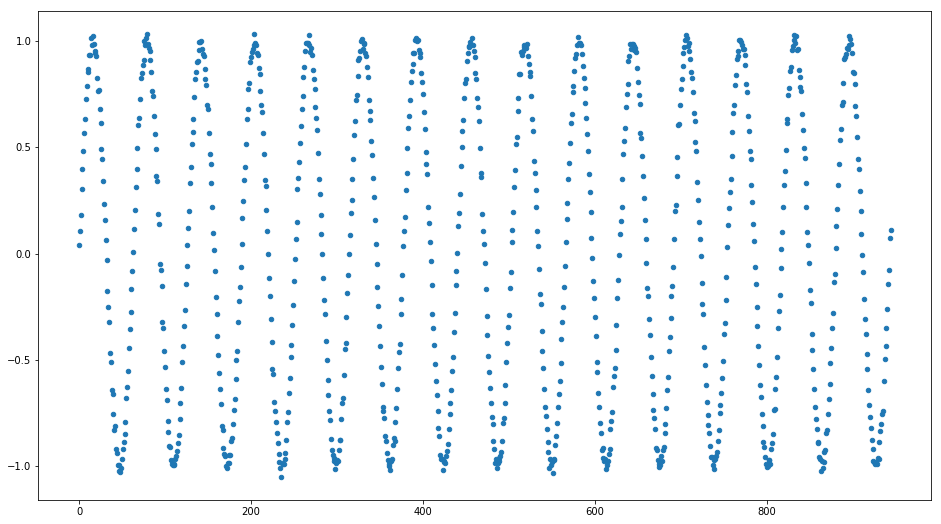

In [25]:
#Standard Deviation of noise we will add to our generated curves
SIGMA = 0.02
#Number of curves we will generate
N = 20

#dataset will hold values of all generated curves
dataset = []

for _ in range(N):
    #Domain of our curve will be 0 to end
    start = np.random.uniform(0, 40)
    end = np.random.uniform(80, 100)
    #We will generate a point for all x values divisible by 0.1
    t = np.arange(0, end, 0.1)
    #Generate values as sin(t) + noise
    x = np.sin(t) + np.random.normal(loc=0.0, scale=SIGMA, size=t.shape)
    #Add generated curve to dataset
    dataset.append(x)

#Plot example curve
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(dataset[0].shape[0]), dataset[0], s=20)
plt.show()

In [26]:
#Each 'data point' in our dataset will be ([y_0,y_1,...,y_(n-1)],[y_1,y_2,...,y_n])
#Our model will predict future values so the output will be of shifted time index.
dataset = [
    (torch.from_numpy(input_seq[:-1]).double(), torch.from_numpy(input_seq[1:]).double()) \
        for input_seq in dataset
]

# RNN Definition

In [27]:
#Definition of our vanilla RNN
class RNN(nn.Module):
    #Initialize RNN module
    def __init__(self, hidden_size):
        
        super().__init__()
        
        #Hidden size determined by argument
        self.hidden_size = hidden_size
        #Initial hidden state of our RNN will be a parameter—it can thus be optimized
        self.init_hidden = torch.nn.Parameter(torch.zeros(1,1,self.hidden_size))
        
        #RNN module input size 1 as inputs correspond to single point values on graph
        self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size)
        #linear mapping used to map outputs of RNN to predictions
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    #Forward pass through RNN.  Maps inputs to outputs additionally returning final hidden state.
    def forward(self, inputs, teacher_force_prob=0.5):
        #Number of points in passed in input
        seq_len = inputs.shape[0]
        #List to contain outputs of the model
        outputs = []
        #Initialize hidden state to the initial hidden state parameter
        h = self.init_hidden
        #For every data point in input
        for i, inp in enumerate(inputs):
            #If it's the first point or with probability teacher_force_prob
            #we use the actual previous value given from the data
            #Otherwise we use what the model outputted last as input
            if i == 0 or np.random.uniform() < teacher_force_prob:
                inp_to_rnn = inp
            else:
                inp_to_rnn = output
            #We reshape input as the RNN module expects (num_time_steps,batch_size,input_size)
            #dimensionality of it's input.  We are manually going through one time step at a time,
            #learning from one example at a time (batch size = 1), and our input size is 1.
            #RNN module outputs final output and hidden state.  Since we are just working with one
            #time step this is simply the next output and next hidden state
            output, h = self.rnn(inp_to_rnn.reshape(1, 1, 1), h)
            #Output will be of size (time_steps=1,batch_size=1,output_size=1) so we squeeze to get
            #a single value.  Then we apply our linear transformation
            output = self.linear(torch.squeeze(output))
            #Append output to our list of outputs
            outputs.append(output)
        #Save final hidden state to return
        final_h = h
        
        outputs = torch.squeeze(torch.cat(outputs))
        
        return outputs, final_h
    
    #Given a set of inputs runs through RNN collecting final hidden state
    #Using hidden state we extrapolate exclusively feeding the output of the 
    #model back in to create a self sustaining model of the future
    def extrapolate(self, inputs, num_futures):
        #We don't need to keep track of gradients here (not used for learning)
        with torch.no_grad():
            #Get final hidden state of RNN after passing through given inputs
            #As well as outputs over the course of the forward pass.
            outputs, final_h = self.forward(inputs)
            
            #Initialize lists to contain future extrapolated points
            future_points = []
            #Initialize hidden state as final hidden state found earlier
            h = final_h
            #Last predicted point initialized to last point predicted by model
            pred_pt = outputs[-1]
            #For every point you want to extrapolate
            for _ in range(num_futures):
                #Output and next hidden state gotten through forward pass
                pred, h = self.rnn(pred_pt.reshape(1, 1, 1), h)
                #Apply linear transformation on output to get predicted point
                pred_pt = self.linear(pred)
                #Append predicted point to list of extrapolated points
                future_points.append(pred_pt.item())
            #Return an ndarray containing modelled and extrapolated points
            return np.concatenate((outputs,future_points), axis = 0)
                


# Training

In [28]:
#Number of Epochs
EPOCHS = 18
#Learning Rate
LR = 0.01
#Momentum Constant
BETA = 0.2
#Dimensionality of RNN Hidden State
HIDDEN_SIZE = 64

#Initialize network
net = RNN(HIDDEN_SIZE).double()

#We will use Mean Squared Loss
criterion = nn.MSELoss()
#Optimize using Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=BETA)

for i in range(EPOCHS):
    #Value to display reset each epoch
    total_loss = 0
    #Online learning - Update weights after each example
    for inputs, target in dataset:
        #We are only interested in the predictions made by the model
        #So only save the outputs given the inputs
        output, _ = net(inputs)
        #'Squeeze' the outputs to reduce to a single dimensional list of predictions
        output = output.reshape(-1)
        #Loss is the mean squared error with the expected targets
        loss = criterion(output, target)
        
        #Zero the gradients before computing new gradients
        net.zero_grad()
        #Compute gradients in a backward pass
        loss.backward()
        #Update the parameters to minimize loss
        optimizer.step()
        
        #Increment the total loss for this Epoch
        total_loss += loss
    #Divide total loss by the length of the dataset to get 'average' total loss  
    total_loss /= len(dataset)
    #Display average loss for Epoch
    print(f"Epoch {i+1}: {total_loss.item()}")
    
    

Epoch 1: 0.5205507483962317
Epoch 2: 0.44783616157144196
Epoch 3: 0.33525188053746435
Epoch 4: 0.15552649902448903
Epoch 5: 0.10544645105369052
Epoch 6: 0.07841514941238456
Epoch 7: 0.06224967577597207
Epoch 8: 0.0422194657129725
Epoch 9: 0.023716662572976856
Epoch 10: 0.008280899792931215
Epoch 11: 0.0030492499547656263
Epoch 12: 0.002469061780726119
Epoch 13: 0.0023791592124823282
Epoch 14: 0.0021624148665551684
Epoch 15: 0.0022211802345601813
Epoch 16: 0.0023075698017347114
Epoch 17: 0.00211595736814962
Epoch 18: 0.002160901141459818


# Extrapolation Demo

ValueError: x and y must be the same size

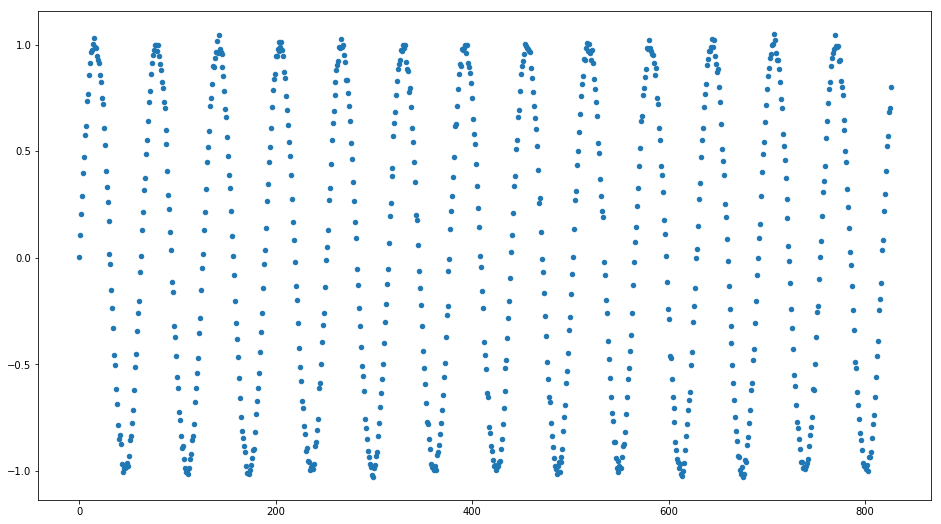

In [32]:
#Number of points we want to extrapolate
num_future = 200

#We will use the first example function in our dataset.  Note the second 0 is to retrieve
#the points [y_0,y_1,...,y_(n-1)]] as we saved earlier. (dataset[i][1]) would get
#[y_1,y_2,...,y_n])
ground = dataset[np.random.randint(0,N)][0]
#Number of points we are given
num_ground = ground.shape[0]
#Our extrapolated points
prediction = net.extrapolate(ground, num_future)

#Plot the extrapolated points along with the given input.
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(num_ground), ground, s=20)
plt.scatter(np.arange(num_ground, num_ground+num_future), prediction, s=10)
plt.show()